# Gyakorlat 4
## Regulariált Logisztikus Regresszió (NemLineáris eset):
### Microchip Anomália:

A feladatunk meghatározni, hogy a mikrocsippek közül a mérési eredmények alapján melyik hibás és melyik nem.

Jelen gyakorlat során kapunk egy adathalmazt, ami nem lineárisan szeparálható. Ennek ellenére így is szeretnénk használni a logisztikus regressziót a klasszifikáció során. Ennek céljából bevezetünk több tulajdonságot (feature-t), sőt polinomiális tulajdonságokat is az adatmátixunkhoz (polinomiális regresszióhoz hasonlóan).

Ebben a feladatban kipróbálásra kerülnek különböző regularizációs paraméterek az adathalmazon, hogy jobban megérthessük miként  hatnak a túltanulás (overfit) jelenségére. Figyeljük meg a változásokat a döntési határon, ahogy a lamdbát változtatjuk majd. Egy kis lambdával észrevehető lesz, hogy a klaszifikáció során szinte nem hibázik, azonban cserébe nagyon bönyolult görbét kapunk. Ez nem a egy jó döntési görbe, vegyük észre, hogy a (-0,25; 1,5) -öt elfogadja, ami egy inkorrekt döntésnek tűnik az adathalmazunk alapján.

Egy nagyobb lambda segítségével azt láthatjuk, hogy egy egyszerűbb döntési határ jön létre, ami nem követi annyira az egyes adatokat így ez alultanult (underfitted).

### 1: Importáljuk be a megfelelő csomagokat majd alakítsuk ki a megfelelő változókat (X,Y,m,n)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data = pd.read_csv('Lab4data.txt', header = None).to_numpy()        # adatok beolvasása a data változóba NumPy tömbként
X = data[:,0:2]                                                     # X rendezése
m,n = X.shape                                                       # adatok száma / feature-k száma
Y = data[:,2].reshape(m,1)                                          # Y rendezése
del data                                                            # felesleges változó törlése

print('X:', X.shape)                    # adattömbök méretének / adatok számának / feature-k számának kiírása
print('Y:', Y.shape)
print('Adatok száma:',m)
print('Feature-ök száma:',n)

X: (118, 2)
Y: (118, 1)
Adatok száma: 118
Feature-ök száma: 2


### 2: Szedjük ki az elemeket az alapján, hogy átmentek e a vizsgálaton és rajzoltassuk is ki őket

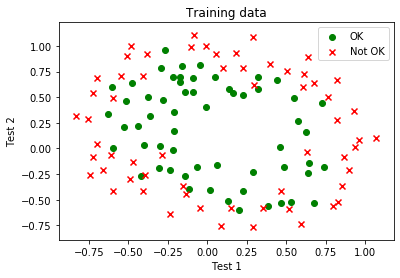

In [3]:
def plotData(X,Y):
    pos = []                                                        # jó elemek listája 
    neg = []                                                        # rossz elemek listája

    for i in range(0,Y.size):                                       # végig megyünk az Y elemein
        if Y[i]==1:                                                 # ha Y értéke 1, akkor X azonos sora megy a pos -ba
            pos.append(X[i,:])
        elif Y[i]==0:                                               # ha Y értéke 0, akkor X azonos sora megy a neg -be
            neg.append(X[i,:])

    pos = np.array(pos)                                             # pos legyen NumPy tömb
    neg = np.array(neg)                                             # neg legyen NumPy tömb

    plt.scatter(pos[:, 0], pos[:, 1], c="g", marker="o", label="OK")        # pos kirajzolása
    plt.scatter(neg[:, 0], neg[:, 1], c="r", marker="x", label="Not OK")    # neg kirajzolása
    plt.title("Training data")
    plt.xlabel("Test 1")
    plt.ylabel("Test 2")
    plt.legend()
    plt.show()

    return pos,neg                                                  # visszaadjuk pos és neg -et a későbbi használatra

pos, neg = plotData(X,Y)                                            # függvény meghívása az adatainkra

Láthatjuk, hogy az adataink nem szeparálhatók lineárisan.

### 3: mapFeature készítése

In [4]:
def mapFeature(X1,X2,deg=6):                            # létrehozunk egy függvényt, ami az 'X1' és 'X2' összeg
                                                        # kombinációját megalkotja X1 | X2 | X1X2| X1^2 | X2^2 ....
    out = np.ones((m,1))                                # deg-ig (alapesetben 6)

    for i in range(1,deg+1):
        for j in range(i+1):
            terms = (X1**(i-j)*X2**j).reshape(m,1)     # maga az egyes kombinációk létrehozása
            out = np.column_stack((out,terms))         # és a függvény kimeneti mátrixába rakása
            
    return out

X=mapFeature(X[:,0],X[:,1])                           # hozzuk létre az X ilyen változatát

### 4: Költségfüggvény

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def costFunctionReg(w,X,Y,Lambda=1):
    m = len(Y)

    pred = sigmoid(X@w)                             # predició
    w1 = np.vstack((np.array([0]),w[1:,:]))         # kizárjuk az első w értékét
    p = Lambda*(w1.transpose() @ w1)/(2*m)          # büntetés

    C = (((-Y).transpose() @ np.log(pred)) - ((1-Y).transpose() @ np.log(1-pred)))/m + p    # költségfüggvény

    grad = (X.transpose() @ (pred -Y) + Lambda*w1)/m                                        # grádiens

    return C,grad

init_w = np.zeros((X.shape[1],1))                   # kezdeti súlyok (tiszta 0)
C, grad =costFunctionReg(init_w,X,Y)                # költségfüggvény / gradiens számolás
print('Cost at initial weight (zeros): ',C)

Cost at initial weight (zeros):  [[0.69314718]]


### 5: Grádiens módszer:


Regularized weight:
 [[ 2.25319932]
 [ 1.44552306]
 [ 2.33283911]
 [-3.57008233]
 [-2.35002884]
 [-3.07090829]
 [ 0.50119267]
 [-0.88407626]
 [-0.69606495]
 [-0.22204243]
 [-2.69560917]
 [ 0.04161168]
 [-1.31573798]
 [-0.80286232]
 [-2.23101395]
 [-0.39638083]
 [-0.43758167]
 [ 0.09476652]
 [-0.69300577]
 [-0.78996079]
 [-0.45416815]
 [-2.01051679]
 [ 0.16446857]
 [-0.59855483]
 [ 0.11471778]
 [-0.73960173]
 [-0.52044034]
 [-1.38532427]]


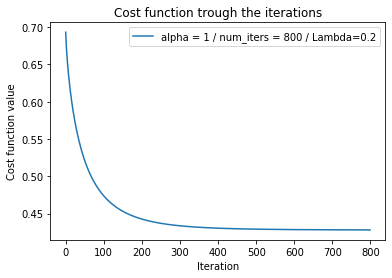

In [9]:
def gradientDescent(X,Y,w,alpha,num_iters,Lambda):                          # grádiens módszer
    C_history = []

    for i in range(num_iters):                                              # iterációszámig futtatjuk
        C, grad = costFunctionReg(w,X,Y,Lambda)
        w = w - (alpha*grad)                                                # súlyok frissítése
        C_history = np.append(C_history,C)                                  # költségfüggvény történet elmentése

    return w, np.array(C_history)

w, C_history = gradientDescent(X,Y,init_w,1,800,0.2)        # futtatás: tanulási ráta:1 / iterációszám: 800 / lamdba: 0.2
print('\nRegularized weight:\n',w)

plt.plot(C_history,label = "alpha = 1 / num_iters = 800 / Lambda=0.2")      # történet kirajzolása
plt.title("Cost function trough the iterations")
plt.xlabel("Iteration")
plt.ylabel("Cost function value")
plt.legend()
plt.show()

### 6: Rajzoljuk ki a döntést

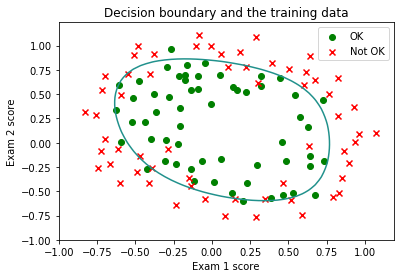

In [12]:
def mapFeaturePlot(x1,x2,deg=6):                                           # létrehozzuk a 
    out = np.ones(1)
    for i in range(1,deg+1):
        for j in range(i+1):
            terms= (x1**(i-j) * x2**j)
            out= np.hstack((out,terms))
    return out

plt.scatter(pos[:, 0], pos[:, 1], c="g", marker="o", label="OK")            # eredeti pozitív eredmények rajzolása
plt.scatter(neg[:, 0], neg[:, 1], c="r", marker="x", label="Not OK")        # eredeti negatív eredmények rajzolása

u_vals = np.linspace(-1,1.,50)                                              # a határ berajzolásához 1 paraméter
v_vals = np.linspace(-1,1.,50)                                              # második paraméter
z=np.zeros((len(u_vals),len(v_vals)))                                       # eredményváltozó inicializálása

for i in range(len(u_vals)):                                                # végigmegyünk az u_vals és v_vals elemein
    for j in range(len(v_vals)):
        z[i,j] = mapFeaturePlot(u_vals[i],v_vals[j]) @ w                        

plt.contour(u_vals,v_vals,z.transpose(),0)                                  # kirajzoljuk contour plottal a döntési határt
plt.title("Decision boundary and the training data")
plt.xlabel("Exam 1 score")
plt.ylabel("Exam 2 score")
plt.legend(loc=0)
plt.show()